<p style="color: #000000; font-size: 32px; font-weight: bold; text-align: center; margin-top: 20px;"> 
Sweet Lift Taxi
</p>
<p style="color: #000000; font-size: 24px; text-align: center; margin-bottom: 20px;">
Modelo de Predicción de Pedidos de Taxis en Aeropuertos
</p>

<hr style="border: .4px solid #000000; width: 70%; margin: 10px auto;">

<p style="color: #000000; font-size: 18px;">
La compañía de taxis Sweet Lift Taxi ha recopilado datos históricos sobre pedidos de taxis en aeropuertos. Para mejorar la disponibilidad de conductores en las horas pico, se desarrollará un modelo que prediga la cantidad de pedidos de taxis en la próxima hora.
</p>

<p style="color: #000000; font-size: 20px; font-weight: bold;">Objetivo del Proyecto:</p>
<p style="color: #000000; font-size: 18px;">
El objetivo de este proyecto es construir un modelo de predicción que estime la cantidad de pedidos de taxis con una métrica RECM no superior a 48 en el conjunto de prueba.
</p>

<p style="color: #000000; font-size: 20px; font-weight: bold;">Instrucciones del Proyecto:</p>
<ul style="color: #000000; font-size: 18px;">
<li><strong>Descarga y procesamiento de datos:</strong> Realizar el remuestreo de los datos por intervalos de una hora.</li>
<li><strong>Análisis exploratorio:</strong> Examinar y comprender las características de los datos.</li>
<li><strong>Entrenamiento de modelos:</strong> Probar diferentes modelos y ajustar hiperparámetros. Se utilizará el 10% del conjunto de datos inicial como muestra de prueba.</li>
<li><strong>Evaluación del modelo:</strong> Probar el modelo con la muestra de prueba y generar conclusiones sobre su desempeño.</li>
</ul>

<p style="color: #000000; font-size: 20px; font-weight: bold;">Descripción de los Datos:</p>
<p style="color: #000000; font-size: 18px;">
Los datos se encuentran en el archivo <code>taxi.csv</code>, el cual contiene dos columnas.
</p>

<p style="color: #000000; font-size: 18px;">
<strong>datetime</strong> — Fecha y hora, en el formatoformato: YYYY-MM-DD HH:MM:SS.
</p>

<p style="color: #000000; font-size: 18px;">
<strong>num_orders</strong> — Cantidad de pedidos de taxi realizados en la fecha y hora correspondientes.
</p>


___

# Librerias 

In [164]:
import pandas as pd 
import numpy as np
import math 
import time

import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import TimeSeriesSplit, train_test_split, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error

# Carga de Datos y Preparación

In [165]:
# Cargar los datos, estableciendo 'datetime' como índice 
data = pd.read_csv('taxi.csv', index_col=[0], parse_dates=[0])

# Agrupar por hora
data = data.resample('h').sum()

# Renombrar la columna a 'orders_per_hour'
data = data.rename(columns={data.columns[0]: 'orders_per_hour'})

# Mostrar información y una muestra aleatoria
data.info()
data.sample(15)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: h
Data columns (total 1 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   orders_per_hour  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


,orders_per_hour
datetime,
2018-05-14 07:00:00,42
2018-03-19 16:00:00,44
2018-06-12 17:00:00,104
2018-06-06 14:00:00,67
2018-08-28 04:00:00,106
2018-03-03 01:00:00,108
2018-04-02 22:00:00,66
2018-04-09 07:00:00,26
2018-06-21 15:00:00,55


La revisión inicial muestra que hay 26,596 registros de órdenes, no hay valores nulos, el tipo de dato es correcto y los registros estan agrupados por hora.    
Vamos a continuar con la descripción de los datos: el rango de fechas, si están ordenados cronológicamente y la búsqueda de duplicados en el índice.

In [166]:
# Rango de fechas 
start_date = data.index.min()
end_date = data.index.max()

print(f'Date range: {start_date} - {end_date}')

Date range: 2018-03-01 00:00:00 - 2018-08-31 23:00:00


In [167]:
# Comprobar si las fechas están en orden ascendente
if data.index.is_monotonic_increasing:
    print("The dates are in ascending order (monotonically increasing).")
else:
    print("The dates are NOT in ascending order.")

The dates are in ascending order (monotonically increasing).


In [168]:
# Verificar si hay duplicados en index
print('Duplicados en el índice:', data.index.duplicated().sum())

Duplicados en el índice: 0


Ahora vamos a ver la **distribución de número de órdenes**.  

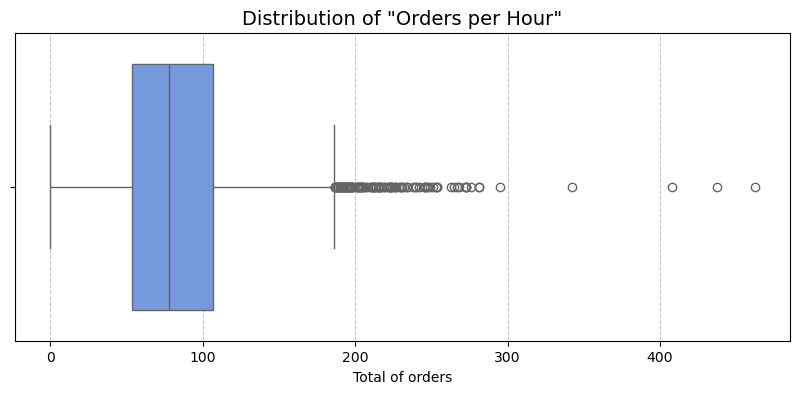

,orders_per_hour
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


In [169]:
# Boxplot 'orders_per_hour'
plt.figure(figsize=(10, 4))  
sns.boxplot(x=data['orders_per_hour'], color="cornflowerblue") 
plt.title('Distribution of "Orders per Hour"', fontsize=14)
plt.xlabel('Total of orders')
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.show()
data.describe()

En promedio, se realizaron **84 viajes por hora**, con una desviación estándar de **45 viajes**, lo que indica una variabilidad significativa en la demanda.

- **Mínimo:** Hubo momentos en los que no se registraron viajes en una hora determinada (**0 viajes**).  
- **Percentil 25 (Q1):** En el 25% de las horas con menor demanda, hubo **54 viajes o menos**.  
- **Mediana (Q2, 50%):** La mitad de las horas registraron **78 viajes o menos**.  
- **Percentil 75 (Q3):** En las horas con mayor demanda, se alcanzaron **107 viajes o más**.  
- **Máximo:** La hora con mayor demanda registró **462 viajes**, lo que sugiere posibles picos en la afluencia de pasajeros, posiblemente relacionados con horarios de vuelos clave.

Estos datos muestran que la demanda de taxis hacia el aeropuerto varía considerablemente a lo largo del día y la semana, con momentos de nula actividad y otros de alta demanda.    


In [170]:
# Calcular el límite superior para detectar outliers usando el método del rango intercuartil (IQR)
# Se calcula el cuartil 75 (Q3) y el cuartil 25 (Q1), luego se usa la fórmula: 
# Q3 + 1.5 * (Q3 - Q1) para establecer el umbral superior de outliers.
upper_limit = data['orders_per_hour'].quantile(0.75) + 1.5 * (data['orders_per_hour'].quantile(0.75) - data['orders_per_hour'].quantile(0.25))

# Contar el número de outliers que superan el límite superior
outliers_count = len(data[data['orders_per_hour'] > upper_limit])

# Calcular el porcentaje de outliers en relación al total de datos
outliers_percentage = round(outliers_count / len(data) * 100, 2)

# Mostrar el % de outliers
print(f'Hay {outliers_count} outliers altos, que representan el {outliers_percentage}% de los valores.')

Hay 121 outliers altos, que representan el 2.74% de los valores.


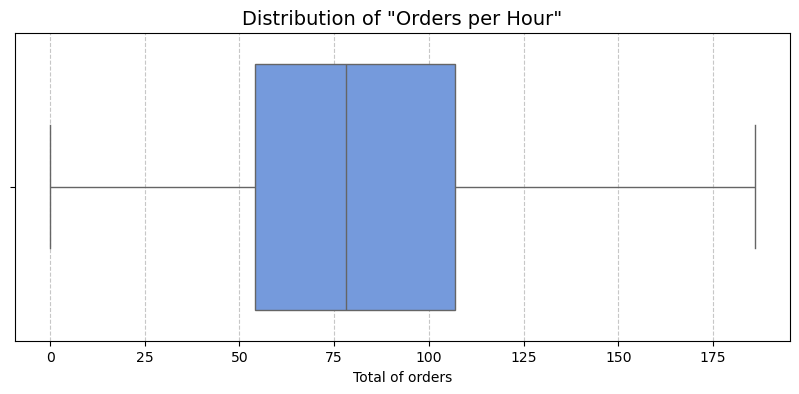

In [171]:
# Recortar los valores de la columna 'orders_per_hour' para asegurarse de que no superen el límite superior.
# 'upper_limit' es el valor máximo que se permite en la columna. 
# Se usa math.floor para redondear hacia abajo el límite si es necesario.

data['orders_per_hour'] = data['orders_per_hour'].clip(upper=math.floor(upper_limit))

# Esto recortará cualquier valor de 'orders_per_hour' que sea mayor que el límite superior 'upper_limit',
# reemplazándolo por 'upper_limit'. Si no hay valores superiores, los valores permanecerán igual.

# Boxplot 'orders_per_hour'
plt.figure(figsize=(10, 4))  
sns.boxplot(x=data['orders_per_hour'], color="cornflowerblue") 
plt.title('Distribution of "Orders per Hour"', fontsize=14)
plt.xlabel('Total of orders')
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.show()

Podemos comprobar visualmente que los outliers se reagruparon correctamente.

---

## Análisis

In [172]:
# Calcular la media móvil con una ventana de 24 horas (1 día)
data['rolling_mean'] = data['orders_per_hour'].rolling(window=24).mean()

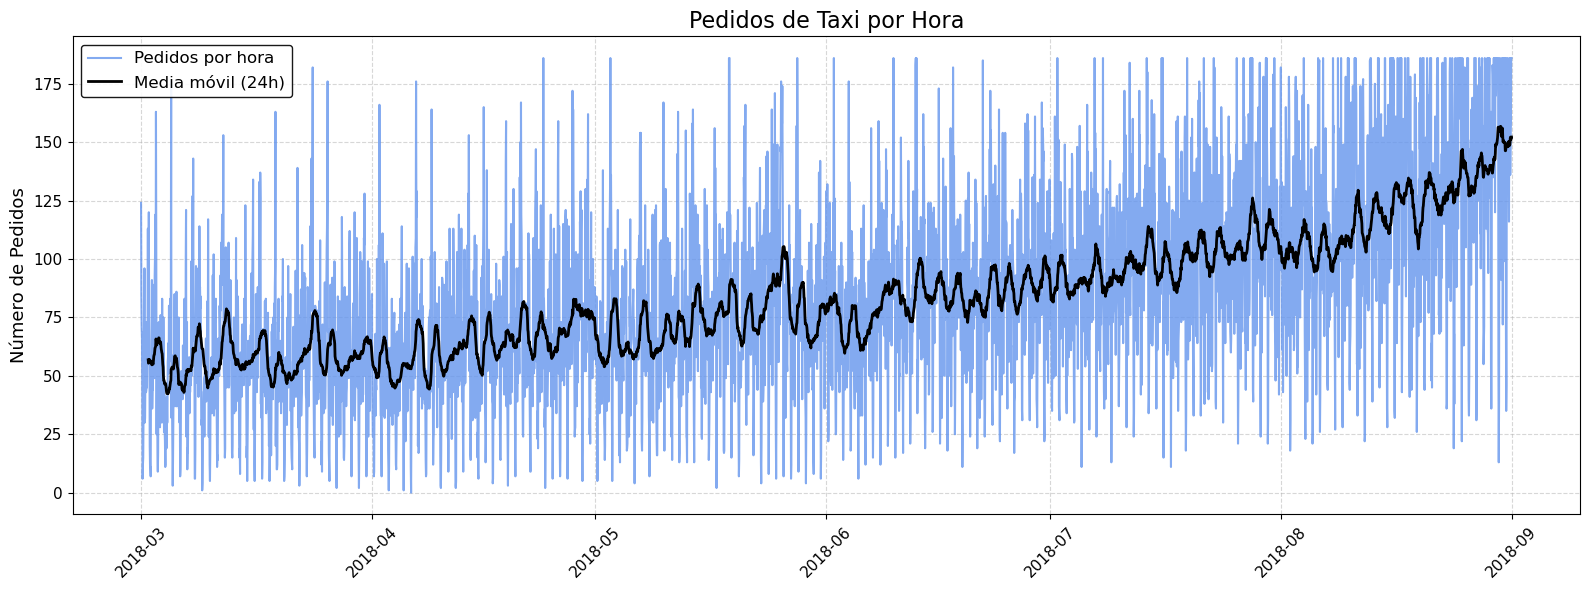

In [173]:
# Configurar la figura
plt.figure(figsize=(16, 6))

# Graficar la serie original de pedidos por hora
plt.plot(data.index, data['orders_per_hour'], label='Pedidos por hora', color='cornflowerblue', linewidth=1.5, alpha=0.8)

# Graficar la media móvil de 24 horas
plt.plot(data.index, data['rolling_mean'], label='Media móvil (24h)', color='black', linewidth=2)
plt.title('Pedidos de Taxi por Hora', fontsize=16)
plt.ylabel('Número de Pedidos', fontsize=13)
plt.grid(True, linestyle='--', alpha=0.5)
plt.xticks(rotation=45, fontsize=11)
plt.yticks(fontsize=11)
plt.legend(loc='upper left', fontsize=12, frameon=True, facecolor='white', edgecolor='black', framealpha=0.9)
plt.tight_layout()
plt.show()

**Análisis de 'Pedidos de Taxi por Hora'**

Desde marzo, el número de pedidos por hora comenzó en un promedio de 50-60 y creció de manera constante hasta alcanzar aproximadamente 150 pedidos por hora en agosto.

Se observan picos durante ciertas horas del día, especialmente por la noche y al mediodía, con tendencias bajas regulares en las primeras horas de la mañana.

La demanda aumentó significativamente en los meses de verano, especialmente entre julio y agosto, mientras que fue menor en primavera.

### Descomposición de los datos 

El siguiente paso es descomponer los datos en tres componentes principales: **tendencia**, **componente estacional** y **residuos**.       
La **tendencia** muestra la dirección general de los datos a lo largo del tiempo, revelando si los pedidos aumentan, disminuyen o se mantienen estables.     
La **componente estacional** destaca patrones repetitivos, como picos diarios o semanales, que pueden estar relacionados con horarios específicos o días de la semana.  
Finalmente, los **residuos** representan lo que no se explica ni por la tendencia ni por la estacionalidad, ayudando a identificar anomalías o ruido en los datos.    
Esta descomposición es clave para entender mejor el comportamiento de los pedidos y tomar    decisiones informadas.   

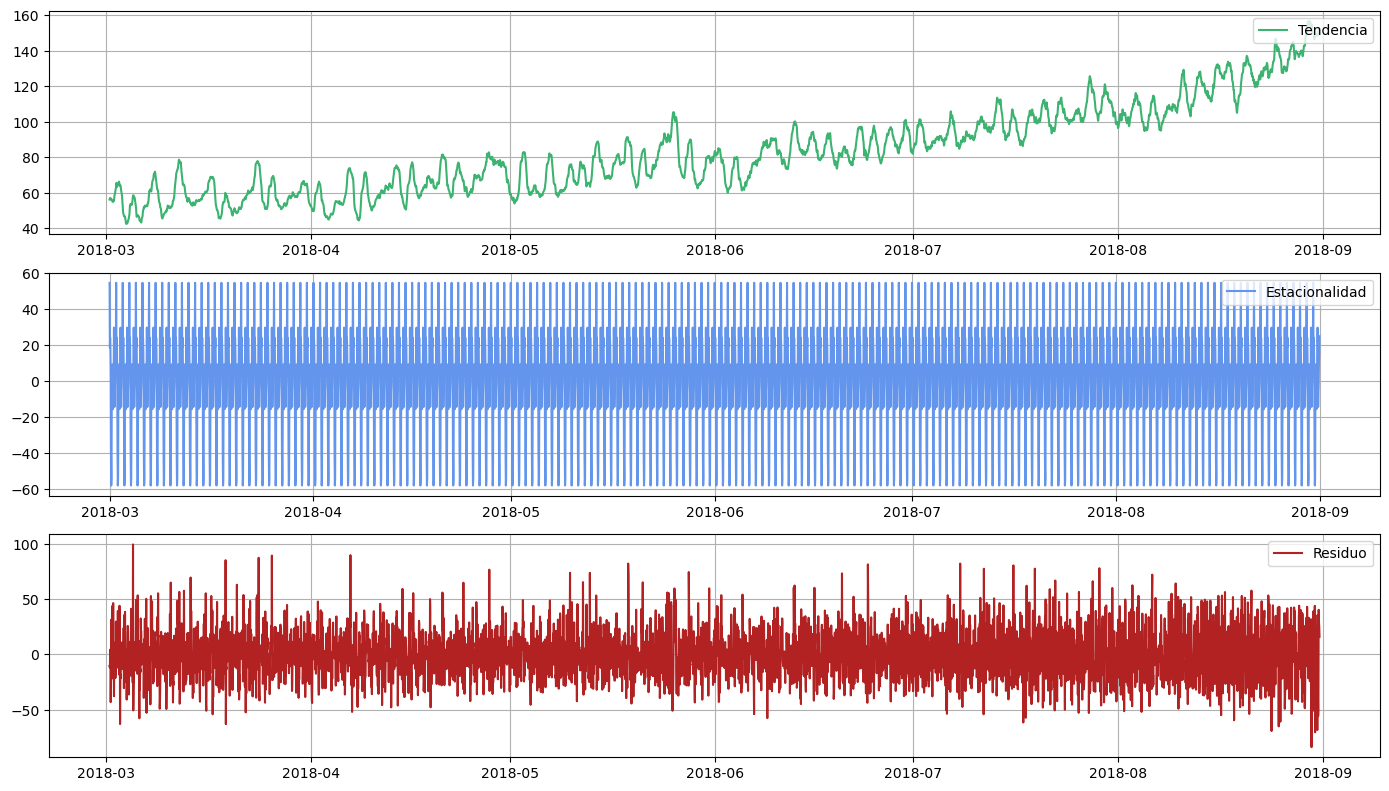

In [174]:
# Descomposición de la serie temporal
decomposition = seasonal_decompose(data['orders_per_hour'], model='additive', period=24)  # Periodo de 24 horas

# Graficar los componentes
plt.figure(figsize=(14, 8))

# Tendencia
plt.subplot(3, 1, 1)
plt.plot(decomposition.trend, label='Tendencia', color='mediumseagreen')
plt.legend(loc='upper right')
plt.grid()

# Estacionalidad
plt.subplot(3, 1, 2)
plt.plot(decomposition.seasonal, label='Estacionalidad', color='cornflowerblue')
plt.legend(loc='upper right')
plt.grid()

# Residuo
plt.subplot(3, 1, 3)
plt.plot(decomposition.resid, label='Residuo', color='firebrick')
plt.legend(loc='upper right')
plt.grid()

# Ajustar el diseño y mostrar gráfico
plt.tight_layout()
plt.show()

**Análisis de descomposición de la serie temporal (marzo - agosto, 2018) de los pedidos de taxis desde el aeropuerto**.

**Tendencia (verde)**: Muestra un crecimiento constante desde marzo (60 pedidos aprox.), con un crecimiento acelerado notablemente en los meses de verano, termina en agosto (140 pedidos aprox.).

**Estacionalidad (azul)**: Muestra un patrón regular y cíclico que se repite diariamente. Las oscilaciones se mantienen constantes entre +40 y -40. 

**Residuo (rojo)**: No muestra tendencias claras, lo que sugiere que los patrones principales están bien capturados en la tendencia y estacionalidad

Estos tres componentes juntos explican el comportamiento completo de los pedidos de taxi, mostrando un negocio en crecimiento con patrones diarios estables y variaciones aleatorias normales.

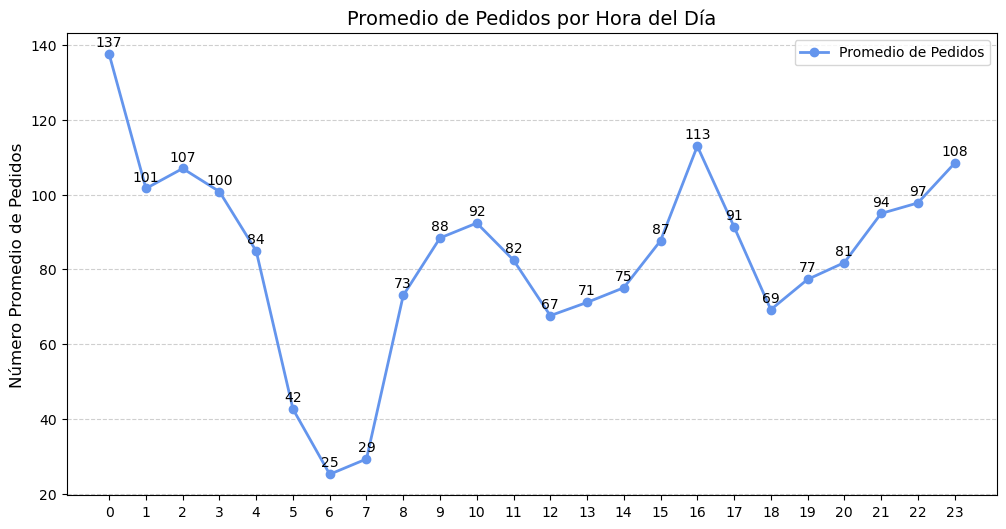

In [175]:
# Agrupar por hora y calcular el promedio de pedidos
hourly_orders = data.groupby(data.index.hour)['orders_per_hour'].mean()

# Configurar la figura
plt.figure(figsize=(12, 6))

# Graficar el número promedio de pedidos por hora como una línea
plt.plot(hourly_orders.index, hourly_orders.values, marker='o', linestyle='-', color='cornflowerblue', linewidth=2, label='Promedio de Pedidos')
plt.title('Promedio de Pedidos por Hora del Día', fontsize=14)
plt.ylabel('Número Promedio de Pedidos', fontsize=12)
plt.xticks(range(24))
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Añadir los valores encima de cada punto de la línea
for i, value in enumerate(hourly_orders.values):
    plt.text(hourly_orders.index[i], value + 2, f'{int(value)}', ha='center', fontsize=10)

# Agregar una leyenda
plt.legend()
# Mostrar el gráfico
plt.show()

**Análisis del promedio de pedidos por hora desde el aeropuerto**

El gráfico muestra el promedio de pedidos de taxi por hora durante un día completo (0-23 horas), revelando varios patrones significativos en la demanda desde el aeropuerto:

El gráfico presenta patrones claros y marcados. El **pico más alto** se registra a las 0 horas (medianoche), con un promedio de 140 pedidos, sugiriendo una intensa actividad relacionada con vuelos nocturnos. Después se observa un **período de baja demanda** entre las 5 y 8 de la mañana, alcanzando su punto más bajo (aproximadamente 25 pedidos) entre las 6 y 7 AM. Durante el día, se identifican **dos picos importantes**: uno alrededor de las 10 AM (90 pedidos) y otro más pronunciado a las 16 horas (4 PM), con cerca de 115 pedidos. En el horario nocturno (20-23 horas), la demanda se mantiene **consistentemente alta**, oscilando entre 95-110 pedidos por hora, indicando una actividad sostenida durante este período. 

**Tendencia general**: La demanda sigue un patrón que coincide con los horarios típicos de operación aeroportuaria, mostrando mayor actividad durante la noche y primeras horas de la madrugada, con una notable disminución en las primeras horas de la mañana.

Esta información sugiere la necesidad de una planificación estratégica en la disponibilidad de taxis: maximizar la flota durante los períodos de alta demanda (medianoche y tarde) y optimizarla durante las horas de menor actividad (madrugada). Esta distribución permitiría una mejor gestión de recursos y una respuesta más eficiente a las necesidades de los usuarios.

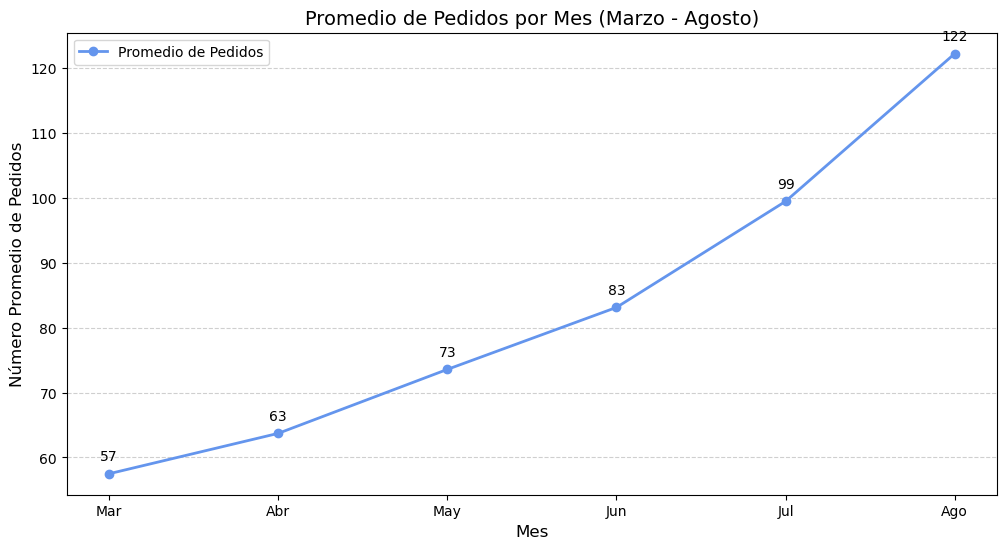

In [176]:
# Agrupar por mes y calcular el promedio de pedidos
monthly_orders = data.groupby(data.index.month)['orders_per_hour'].mean()

# Filtrar solo los meses de marzo a agosto
months = range(3, 9)  # Marzo (3) a Agosto (8)
monthly_orders = monthly_orders.loc[months]

# Configurar la figura
plt.figure(figsize=(12, 6))

# Graficar el número promedio de pedidos por mes como una línea
plt.plot(monthly_orders.index, monthly_orders.values, marker='o', linestyle='-', color='cornflowerblue', linewidth=2, label='Promedio de Pedidos')
plt.title('Promedio de Pedidos por Mes (Marzo - Agosto)', fontsize=14)
plt.xlabel('Mes', fontsize=12)
plt.ylabel('Número Promedio de Pedidos', fontsize=12)
# Ajustar el eje x para mostrar solo los meses de marzo a agosto
plt.xticks(monthly_orders.index, labels=['Mar', 'Abr', 'May', 'Jun', 'Jul', 'Ago'])
# Mostrar cuadrícula en el eje Y
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Añadir los valores encima de cada punto de la línea
for i, value in enumerate(monthly_orders.values):
    plt.text(monthly_orders.index[i], value + 2, f'{int(value)}', ha='center', fontsize=10)

# Agregar una leyenda
plt.legend()
# Mostrar el gráfico
plt.show()

El perio de datos abarca de primavera a verano, podemos ver que conforme aumentan las temperaturas, aumentas las llegadas al aeropuerto. 

El gráfico muestra un crecimiento constante en el total de pedidos desde la primavera (marzo-mayo) hasta el verano (junio-agosto). Al inicio de la primavera, en **marzo**, el total de pedidos es de 57, aumentando ligeramente a **63 pedidos en abril** y llegando a **73 pedidos en mayo**. Esta tendencia ascendente continúa durante la transición al verano, donde **junio** alcanza 83, **julio** registra un aumento más notable con 99, y **agosto** marca el pico más alto con de 122 pedidos.

La línea de tendencia negra refleja un crecimiento constante y acelerado, especialmente pronunciado durante los meses de verano. Este patrón puede explicarse por factores como el **aumento del turismo en verano**, la **mayor actividad de vuelos en temporada alta** y las **mejores condiciones climáticas**, que favorecen los viajes y, por tanto, la demanda de taxis.

## Entrenamiento de Modelo  y Prueba

**Se crean características para el pronóstico:**  
   Se generan variables que ayudarán a los modelos a predecir la demanda. Estas características incluyen información relevante como fechas, valores pasados y tendencias.

**Exploración de características clave:**  
   Se utilizan las siguientes características para los modelos predictivos (excepto para el modelo constante):  
   - **Características del calendario:**  como mes, día del mes y día de la semana.  
   - **Características de desfase:** Valores anteriores de pedidos para identificar patrones de aumento o disminución.  
   - **Característica de media móvil:** Captura la tendencia general de la serie temporal.

**Entrenamiento de modelos con diferentes hiperparámetros:**  
   Se prueban varios modelos predictivos, ajustando sus hiperparámetros para encontrar la mejor combinación que mejore la precisión de las predicciones.

In [177]:
# Se elimina para crear una actualizada
data = data.drop('rolling_mean', axis = 1)

In [178]:
# Crear características basadas en el tiempo
data['hour'] = data.index.hour  # Hora del día
data['day_of_week'] = data.index.dayofweek  # Día de la semana (0 = Lunes, 6 = Domingo)
data['day_of_month'] = data.index.day  # Día del mes
data['week_of_year'] = data.index.isocalendar().week  # Semana del año

# Crear una característica binaria para los fines de semana
data['is_weekend'] = data['orders_per_hour'].apply(lambda x: 1 if x >= 5 else 0)

# Crear características de rezago (lags)
for lag in [1, 2, 3, 24, 168]:  # Retrasos de 1, 2, 3 horas, 1 día (24h) y 1 semana (168h)
    data[f'lag_{lag}'] = data['orders_per_hour'].shift(lag)

# Crear características de media móvil
data['rolling_mean_3'] = data['orders_per_hour'].shift(1).rolling(window=3).mean()  # Media móvil de 3 horas
data['rolling_mean_24'] = data['orders_per_hour'].shift(1).rolling(window=24).mean()  # Media móvil de 24 horas

# Eliminar filas con valores NaN
data.dropna(inplace=True)

# Mostrar las primeras filas del dataframe
display(data.head())

,orders_per_hour,hour,day_of_week,day_of_month,week_of_year,is_weekend,lag_1,lag_2,lag_3,lag_24,lag_168,rolling_mean_3,rolling_mean_24
datetime,,,,,,,,,,,,,
2018-03-08 00:00:00,143,0,3,8,10,1,94.0,127.0,108.0,100.0,124.0,109.666667,60.041667
2018-03-08 01:00:00,78,1,3,8,10,1,143.0,94.0,127.0,121.0,85.0,121.333333,61.833333
2018-03-08 02:00:00,65,2,3,8,10,1,78.0,143.0,94.0,24.0,71.0,105.000000,60.041667
2018-03-08 03:00:00,68,3,3,8,10,1,65.0,78.0,143.0,66.0,66.0,95.333333,61.750000
2018-03-08 04:00:00,60,4,3,8,10,1,68.0,65.0,78.0,73.0,43.0,70.333333,61.833333


**División de datos**

In [179]:
# Configurar validación cruzada para series temporales con 5 divisiones
# TimeSeriesSplit divide los datos en varias particiones, respetando el orden temporal
# Cada "split" usará más datos de entrenamiento mientras se evalúa con los datos futuros
tss = TimeSeriesSplit(n_splits=5)

In [180]:
# Separar características (features) y variable objetivo (target: 'orders_per_hour')
features = data.drop(columns=['orders_per_hour'])
target = data['orders_per_hour']

# Separar el conjunto de datos en entrenamiento y prueba
# - test_size=0.1: 10% de los datos se reservan para prueba
# - shuffle=False: No mezclar los datos (útil para series temporales o datos secuenciales)
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.1, shuffle=False
)

# Verificar los tamaños de los conjuntos creados
print('Train shape (features): ', features_train.shape)  
print('Test shape (features): ', features_test.shape)
print('Train shape (target): ', target_train.shape)
print('Test shape (target): ', target_test.shape)

Train shape (features):  (3823, 12)
Test shape (features):  (425, 12)
Train shape (target):  (3823,)
Test shape (target):  (425,)


### Modelo 1: Regresión Lineal (LinearRegression)

In [181]:
# Entrenar el modelo de regresión lineal
linear_model = LinearRegression()
linear_model.fit(features_train, target_train)

# Predecir y evaluar
linear_pred = linear_model.predict(features_test)
linear_rmse = np.sqrt(mean_squared_error(target_test, linear_pred))
print(f"Regresión Lineal\n RMSE: {linear_rmse:.2f}")

Regresión Lineal
 RMSE: 25.82


### Modelo 2: Árbol de Decisión (DecisionTreeRegressor)
Se utiliza RandomizedSearchCV para optimizar los hiperparámetros.

In [182]:
# Definir los hiperparámetros a optimizar
param_dist = {
    'max_depth': [None, 5, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None] 
}

# Crear el modelo y RandomizedSearchCV
tree_model = DecisionTreeRegressor(random_state=12345)
tree_search = RandomizedSearchCV(tree_model, param_distributions=param_dist, n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42)

# Entrenar y optimizar
tree_search.fit(features_train, target_train)

# Predecir y evaluar
tree_pred = tree_search.predict(features_test)
tree_rmse = np.sqrt(mean_squared_error(target_test, tree_pred))
print(f"Árbol de Decisión\n RMSE: {tree_rmse:.2f}")
print(f"Mejores hiperparámetros:\n {tree_search.best_params_}")

Árbol de Decisión
 RMSE: 29.28
Mejores hiperparámetros:
 {'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 10}


### Modelo 3: Bosque Aleatorio (RandomForestRegressor)
Se utiliza RandomizedSearchCV para optimizar los hiperparámetros.

In [188]:
# Definir los hiperparámetros a optimizar
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}

# Crear el modelo y RandomizedSearchCV
forest_model = RandomForestRegressor(random_state=12345)
forest_search = RandomizedSearchCV(forest_model, param_distributions=param_dist, n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42)

# Entrenar y optimizar
forest_search.fit(features_train, target_train)

# Predecir y evaluar
forest_pred = forest_search.predict(features_test)
forest_rmse = np.sqrt(mean_squared_error(target_test, forest_pred))
print(f"Bosque Aleatorio\n RMSE: {forest_rmse:.2f}")
print(f"Mejores hiperparámetros:\n {forest_search.best_params_}")

Bosque Aleatorio
 RMSE: 28.10
Mejores hiperparámetros:
 {'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 15}


### Modelo 4: LightGBM (LGBMRegressor)
Se utiliza RandomizedSearchCV para optimizar los hiperparámetros.

In [184]:
# Definir los hiperparámetros a optimizar
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15],
    'learning_rate': [0.01, 0.05, 0.1],
    'num_leaves': [31, 50, 100],
    'min_child_samples': [10, 20, 30]
}

# Crear el modelo y RandomizedSearchCV
lgbm_model = LGBMRegressor(random_state=12345)
lgbm_search = RandomizedSearchCV(lgbm_model, param_distributions=param_dist, n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42)

# Entrenar y optimizar
lgbm_search.fit(features_train, target_train)

# Predecir y evaluar
lgbm_pred = lgbm_search.predict(features_test)
lgbm_rmse = np.sqrt(mean_squared_error(target_test, lgbm_pred))
print(f"\nLightGBM\n RMSE: {lgbm_rmse:.2f}")
print(f"Mejores hiperparámetros:\n {lgbm_search.best_params_}")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000252 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1465
[LightGBM] [Info] Number of data points in the train set: 3058, number of used features: 11
[LightGBM] [Info] Start training from score 84.650098
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000172 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1416
[LightGBM] [Info] Number of data points in the train set: 3059, number of used features: 11
[LightGBM] [Info] Start training from score 72.523047
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000213 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1465
[LightGBM] [Info] Number of data points in the train set: 3058, number of used features: 11
[LightGBM] [Info] Start training from score 84.650098
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000181 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1463
[LightGBM] [Info] Number of data points in the train set: 3058, number of used features: 11
[LightGBM] [Info] Start training from score 79.734140
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000127 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1416
[LightGBM] [Info] Number of data points in the train set: 3059, number of used features: 11
[LightGBM] [Info] Start training from score 72.523047
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000152 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1462
[LightGBM] [Info] Number of data points in the train set: 3058, number of used features: 11
[LightGBM] [Info] Start training from score 82.405821
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

### Modelo 5: CatBoost (CatBoostRegressor)
Se utiliza RandomizedSearchCV para optimizar los hiperparámetros.

In [185]:
# Definir los hiperparámetros a optimizar
param_dist = {
    'iterations': [100, 200, 300],
    'depth': [4, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1],
    'l2_leaf_reg': [1, 3, 5]
}

# Crear el modelo y RandomizedSearchCV
catboost_model = CatBoostRegressor(random_state=12345, verbose=0)
catboost_search = RandomizedSearchCV(catboost_model, param_distributions=param_dist, n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42)

# Entrenar y optimizar
catboost_search.fit(features_train, target_train)

# Predecir y evaluar
catboost_pred = catboost_search.predict(features_test)
catboost_rmse = np.sqrt(mean_squared_error(target_test, catboost_pred))
print(f"CatBoost\n- RMSE: {catboost_rmse:.2f}")
print(f"Mejores hiperparámetros:\n {catboost_search.best_params_}")

CatBoost
- RMSE: 27.63
Mejores hiperparámetros:
 {'learning_rate': 0.05, 'l2_leaf_reg': 5, 'iterations': 200, 'depth': 8}


In [189]:
# Crear un diccionario con los resultados
results = {
    "Regresión Lineal": {"RMSE": linear_rmse},
    "Árbol de Decisión": {"RMSE": tree_rmse},
    "Bosque Aleatorio": {"RMSE": forest_rmse},
    "LightGBM": {"RMSE": lgbm_rmse},
    "CatBoost": {"RMSE": catboost_rmse}
}

# Convertir el diccionario en un DataFrame
results_df = pd.DataFrame.from_dict(results, orient='index')
# Ordenar el DataFrame por la columna 'RMSE' de menor a mayor
results_df = results_df.sort_values(by='RMSE', ascending=True)

# Mostrar la tabla
print('\nResumen de resultados:\n', results_df)


Resumen de resultados:
                         RMSE
Regresión Lineal   25.820724
CatBoost           27.632752
Bosque Aleatorio   28.100823
Árbol de Decisión  29.278586
LightGBM           29.293611


**Todos los modelos tienen un RMSE menor a 48** 

Aunque el modelo de **Regresión Lineal** tiene el RMSE más bajo, los modelos basados en árboles de decisión, como **CatBoost** y **Bosque Aleatorio**, tienen un rendimiento comparable y podrían ser preferibles si se trata de capturar relaciones más complejas. El **Árbol de Decisión** y **LightGBM** también están funcionando razonablemente bien, pero su desempeño depende más de cómo se ajusten los hiperparámetros. A pesar de estas diferencias, todos los modelos son efectivos para las predicciones y tienen un rendimiento aceptable dentro del margen establecido (RMSE menor a 48).

### Análisis de los Modelos en el Conjunto de Prueba

### Bosque Aleatorio

In [198]:
%%time
# Definir el modelo CatBoost
catboost_model = CatBoostRegressor(
    iterations=200,  # Número de iteraciones
    depth=5,         # Profundidad del árbol
    learning_rate=0.05,  # Tasa de aprendizaje
    random_state=12345,  # Semilla para reproducibilidad
    verbose=0         # Silenciar los logs
)

# Entrenar el modelo
catboost_model.fit(features_train, target_train)
# Predecir en el conjunto de prueba
catboost_pred = catboost_model.predict(features_test)

# Calcular el RMSE
catboost_rmse = np.sqrt(mean_squared_error(target_test, catboost_pred))
print(f"CatBoost - RMSE en conjunto de prueba: {catboost_rmse:.2f}")

CatBoost - RMSE en conjunto de prueba: 27.09
CPU times: user 267 ms, sys: 186 ms, total: 453 ms
Wall time: 131 ms


### CatBoost Regressor

In [197]:
%%time
# Definir el modelo Bosque Aleatorio
forest_model = RandomForestRegressor(
    n_estimators=200,  # Número de árboles
    max_depth=5,       # Profundidad máxima del árbol
    random_state=12345    # Semilla para reproducibilidad
)

# Entrenar el modelo
forest_model.fit(features_train, target_train)

# Predecir en el conjunto de prueba
forest_pred = forest_model.predict(features_test)

# Calcular el RMSE
forest_rmse = np.sqrt(mean_squared_error(target_test, forest_pred))
print(f"Bosque Aleatorio - RMSE en conjunto de prueba: {forest_rmse:.2f}")

Bosque Aleatorio - RMSE en conjunto de prueba: 29.06
CPU times: user 889 ms, sys: 5.12 ms, total: 895 ms
Wall time: 892 ms


**Comparacion de resultados de CatBoost y Bosque Aleatorio**     


| Modelo             | RMSE en Conjunto de Prueba | Tiempo de Ejecución (Wall Time) |
|--------------------|----------------------------|----------------------------------|
| **CatBoost**       | 27.09                      | 131 ms                          |
| **Bosque Aleatorio** | 29.06                     | 892 ms                          |


**CatBoost** ha mostrado un RMSE ligeramente más bajo (27.09) que **Bosque Aleatorio** (29.06), lo que indica un mejor desempeño en este conjunto de datos.
**CatBoost** también es más rápido, con un tiempo de ejecución de 131 ms, mientras que **Bosque Aleatorio** toma 892 ms, lo que sugiere que CatBoost es más eficiente en términos de tiempo para este conjunto de datos.

Ambos modelos tienen un rendimiento bastante bueno, **CatBoost parece ser más eficiente tanto en precisión como en tiempo de ejecución**.

# Lista de revisión

- [x] Jupyter Notebook está abierto.
- [x] El código no tiene errores.
- [x] Las celdas con el código han sido colocadas en el orden de ejecución.
- [x] Los datos han sido descargados y preparados
- [x] Se ha realizado el paso 2: los datos han sido analizados.
- [x] Se entrenó el modelo y se seleccionaron los hiperparámetros.
- [x] Se han evaluado los modelos. Se expuso una conclusión.
- [x] La *RECM* para el conjunto de prueba no es más de 48.